In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image
%matplotlib inline
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

### Gradient boosting

You may recall that we last encountered gradients when discussing the gradient descent algorithm in the context of fitting linear regression models.  For a particular regression model with n parameters, an n+1 dimensional space existed defined by all the parameters plus the cost/loss function to minimize.  The combination of parameters and loss function define a surface within the space.  The regression model is fitted by moving down the steepest 'downhill' gradient until we reach the lowest point of the surface, where all possible gradients are 'uphill.'  The final model is made up of the parameter estimates that define that location on the surface.

Throughout all iterations of the gradient descent algorithm for linear regression, one thing remains constant: The underlying data used to estimate the parameters and calculate the loss function never changes.  In gradient boosting, however, the underlying data do change.  

Each time we run a decision tree, we extract the residuals.  Then we run a new decision tree, using those residuals as the outcome to be predicted.  After reaching a stopping point, we add together the predicted values from all of the decision trees to create the final gradient boosted prediction.

Gradient boosting can work on any combination of loss function and model type, as long as we can calculate the derivatives of the loss function with respect to the model parameters.  Most often, however, gradient boosting uses decision trees, and minimizes either the  residual (regression trees) or the negative log-likelihood (classification trees).  

Let’s go through a simple regression example using Decision Trees as the base predictors (of course Gradient Boosting also works great with regression tasks). This is called Gradient Tree Boosting, or Gradient Boosted Regression Trees. First, let’s fit a `DecisionTreeRegressor` to the training set.

In [2]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [3]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now train a second `DecisionTreeRegressor` on the residual errors made by the first predictor:

In [4]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Then we train a third regressor on the residual errors made by the second predictor:



In [5]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [6]:
X_new = np.array([[0.8]])

In [7]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [8]:
y_pred

array([0.75026781])

The figure below represents the predictions of these three trees in the left column, and the ensemble’s predictions in the right column. In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

**<font color='teal'>Run the below cell to develop a visual representation.</font>**

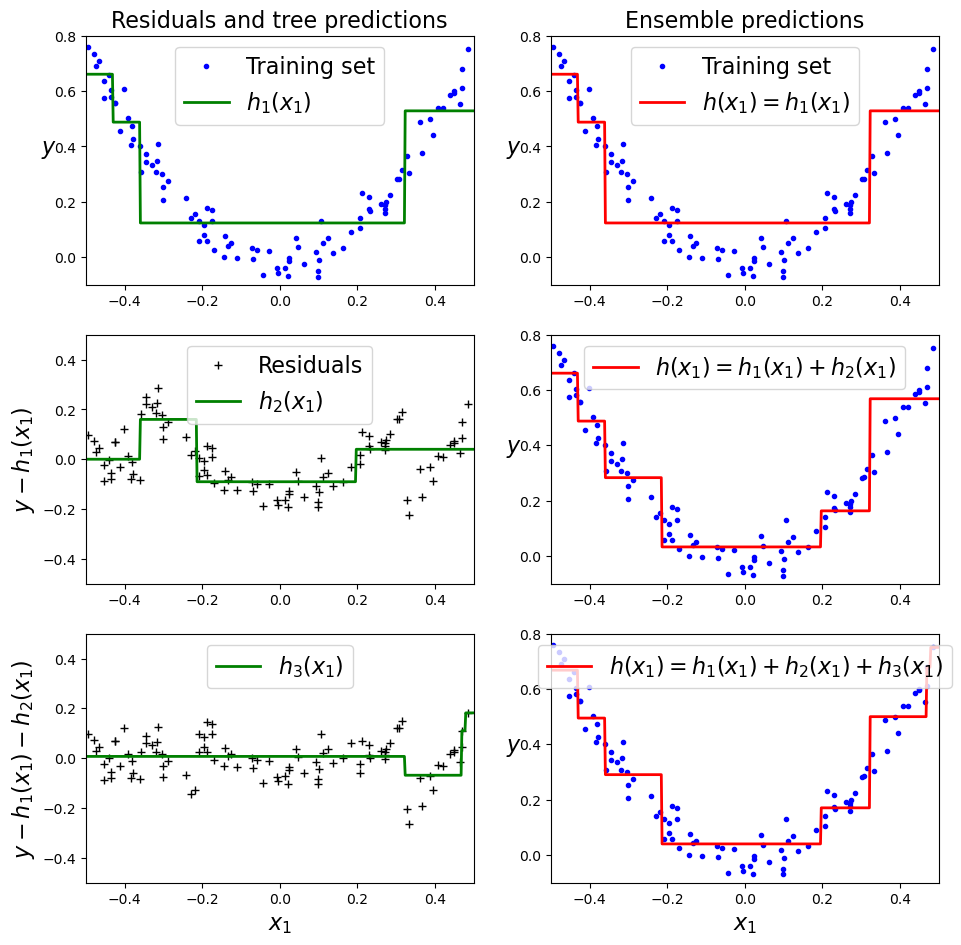

In [9]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

#save_fig("gradient_boosting_plot")
plt.show()

Now that you have solid understanding of Gradient Boosting in the regression scenario, let's apply the same algorithm to a classification problem. Specifically, the Titanic dataset and predicting survival.

**<font color='teal'>Use pandas read csv to load in the Titantic data set into a dataframe called df.</font>**

Hint: in this case you can use [dropna()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) to just throw away any incomplete rows. For the purpose of this exercise we will disregard them but obviously in the real world you need to be much more careful and decide how to handle incomplete observations. 

In [10]:
pwd

'/Users/marciobernardo/Springboard/Python/Projects/Gradient_Boosting_Case_Study'

In [18]:
path = '/Users/marciobernardo/Springboard/Python/Projects/Gradient_Boosting_Case_Study/titanic.csv'
df = pd.read_csv(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [19]:
df.Cabin.head(20)

0      NaN
1      C85
2      NaN
3     C123
4      NaN
5      NaN
6      E46
7      NaN
8      NaN
9      NaN
10      G6
11    C103
12     NaN
13     NaN
14     NaN
15     NaN
16     NaN
17     NaN
18     NaN
19     NaN
Name: Cabin, dtype: object

## For this data set dropping all the row with NaN would significantly reduce the number of rows (observations) because of Cabin feature, which would impact the predictive capability of any model. Cabin is closely realted to Pclass, fare and ticket; Therefore, I will delete Cabin feature and then delete the null rows.

In [20]:
df.drop(['Cabin'], axis =1, inplace =True)
df.dropna(inplace=True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          712 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Embarked     712 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 66.8+ KB


The data set now has 11 columns and 712 observations

**<font color='teal'>Print the levels of the categorical data using 'select_dtypes'. </font>**

In [34]:
dfo = df.select_dtypes(include = 'object')
print(dfo)

                                                  Name     Sex  \
0                              Braund, Mr. Owen Harris    male   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female   
2                               Heikkinen, Miss. Laina  female   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   
4                             Allen, Mr. William Henry    male   
..                                                 ...     ...   
885               Rice, Mrs. William (Margaret Norton)  female   
886                              Montvila, Rev. Juozas    male   
887                       Graham, Miss. Margaret Edith  female   
889                              Behr, Mr. Karl Howell    male   
890                                Dooley, Mr. Patrick    male   

               Ticket Embarked  
0           A/5 21171        S  
1            PC 17599        C  
2    STON/O2. 3101282        S  
3              113803        S  
4              373450        S  
..       

**<font color='teal'>Create dummy features for the categorical features and add those to the 'df' dataframe. Make sure to also remove the original categorical columns from the dataframe.</font>**

In [35]:
df = pd.DataFrame(df.drop(dfo.columns,axis =1)).merge(pd.get_dummies(dfo.drop(['Name','Ticket'],axis =1)),left_index=True,right_index=True).drop(['PassengerId'],axis =1)
print(df.shape)
df.head()

(712, 11)


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


**<font color='teal'>Print the null values for each column in the dataframe.</font>**

In [36]:
df.isnull().any()

Survived      False
Pclass        False
Age           False
SibSp         False
Parch         False
Fare          False
Sex_female    False
Sex_male      False
Embarked_C    False
Embarked_Q    False
Embarked_S    False
dtype: bool

**<font color='teal'>Create the X and y matrices from the dataframe, where y = df.Survived </font>**

In [37]:
X = df.drop('Survived',axis=1)
y = df.Survived

**<font color='teal'>Apply the standard scaler to the X matrix.</font>**

In [39]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

**<font color='teal'>Split the X_scaled and y into 75/25 training and testing data subsets..</font>**

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size = 0.25, random_state = 123)

**<font color='teal'>Run the cell below to test multiple learning rates in your gradient boosting classifier.</font>**

In [46]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.818
Accuracy score (validation): 0.758

Learning rate:  0.1
Accuracy score (training): 0.818
Accuracy score (validation): 0.764

Learning rate:  0.25
Accuracy score (training): 0.835
Accuracy score (validation): 0.792

Learning rate:  0.5
Accuracy score (training): 0.854
Accuracy score (validation): 0.803

Learning rate:  0.75
Accuracy score (training): 0.858
Accuracy score (validation): 0.798

Learning rate:  1
Accuracy score (training): 0.861
Accuracy score (validation): 0.798



**<font color='teal'>Apply the best learning rate to the model fit and predict on the testing set. Print out the confusion matrix and the classification report to review the model performance.</font>**

In [97]:
gb_model = GradientBoostingClassifier(n_estimators=20, learning_rate = 1, max_features=3, max_depth = 3, random_state = 123)
gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)

In [99]:
print(f'The confusion matrix of the model:\n {confusion_matrix(y_test, y_pred)}')

The confusion matrix of the model:
 [[89 16]
 [24 49]]


In [100]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       105
           1       0.75      0.67      0.71        73

    accuracy                           0.78       178
   macro avg       0.77      0.76      0.76       178
weighted avg       0.77      0.78      0.77       178



**<font color='teal'>Calculate the ROC for the model as well.</font>**

In [101]:
y.value_counts(normalize =True)

0    0.595506
1    0.404494
Name: Survived, dtype: float64

In [102]:
# generate a no skill prediction (majority class) 
ns_prediction = [0 for _ in range(len(y_test))]
model_prediction = gb_model.predict(X_test)

In [103]:
#ROC scores
from sklearn.metrics import roc_auc_score
ns_auc = roc_auc_score(y_test, ns_prediction)
model_auc = roc_auc_score(y_test, model_prediction)

print(f'No Skill Prediction: ROC AUC = {ns_auc.round(3)}')
print(f'Gradient Boosting Classifier: ROC AUC = {model_auc.round(3)}')

No Skill Prediction: ROC AUC = 0.5
Gradient Boosting Classifier: ROC AUC = 0.759


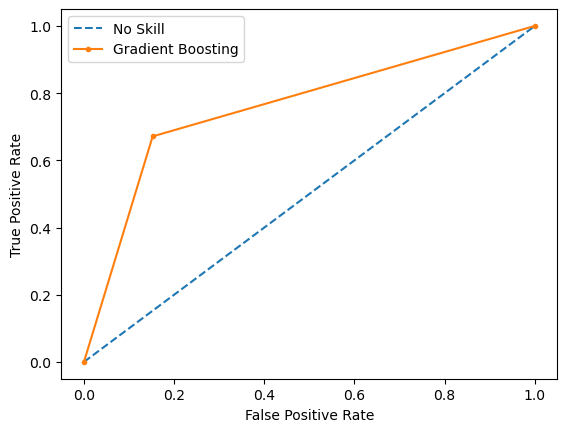

In [104]:
# ROC plot
ns_fpr, ns_tpr, thresholds = roc_curve(y_test, ns_prediction)
model_fpr, model_tpr, thresholds = roc_curve(y_test, model_prediction)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(model_fpr, model_tpr, marker='.', label='Gradient Boosting')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## ROC is not the best metric to evaluate an imbalanced data set. The Titanic data set is imbalenced 59.5% died and 40.5% survived; Therefore, we should use the Precision Recall curve to evaluate the model

In [109]:
from sklearn.metrics import  precision_recall_curve
from sklearn.metrics import  f1_score

model_prob = gb_model.predict_proba(X_test)
# Keeping only probability of survivel
model_prob = model_prob[:,1]

model_precision, model_recall, _ = precision_recall_curve(y_test, model_prob)
model_f1, model_auc = f1_score(y_test, y_pred), auc(model_recall, model_precision)
# summarize scores
print(f'Gradient Boosting Model: f1= {model_f1.round(3)} auc= {model_auc.round(3)}')

Gradient Boosting Model: f1= 0.71 auc= 0.75


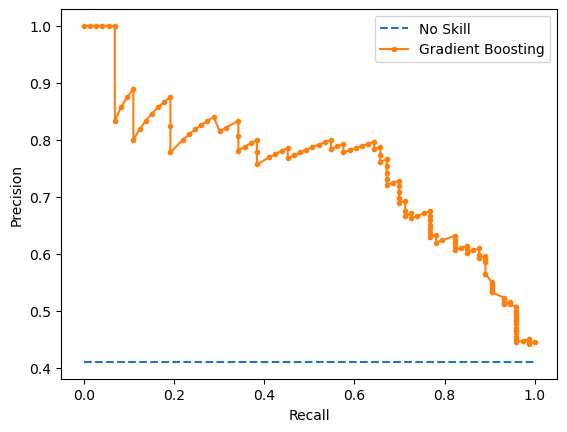

In [111]:
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(model_recall, model_precision, marker='.', label='Gradient Boosting')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()